# Generate Stem Plot with ABE and CBE Tiling Data

The purpose of this notebook is to generate the stem plot in Figure 7b. This notebook was also used to generate stem plots in Figure 5e and 5f.

This notebook plots the z-scored average LFC for each guide along the length of the protein. Guides are represented twice (once with the ABE and once with the CBE), and colored by mutation type (missense, nonsense, silent). All guides that were chosen for validation are individually labelled.

A bar plot is also generated with the same y-axis. The bar plot shows guides targeting introns/UTRs, guides predicted to make no edit, guides predicted to target a splice site, as well as all intergenic and non-targeting control guides.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings, os
import numpy as np
import gpplot as gpp
from matplotlib import rc
#color_dict = colors.get_colors()

# Set default settings for plotting
warnings.filterwarnings('ignore')
sns.set(style='ticks',context='paper')
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [2]:
def get_colors():
	color_dict = {
		'Nonsense':sns.color_palette('Set2')[5],
		'Splice site':sns.color_palette('Set2')[4],
		'Missense':sns.color_palette('Set2')[3],
		'Intron':sns.color_palette('Set2')[6],
		'Silent':sns.color_palette('Set2')[2],
		'UTR':'#a45ab0',
		'No edits':sns.color_palette('Set2')[1],
		'orange':'#fc8d62',
		'teal':'#66c2a5',
		'lime':'#a6d854',
		'pink':'#e78ac3',
		'purple':'#8da0cb',
		'Targeting control':sns.color_palette('Set2')[7],
	}
	return color_dict


In [3]:
color_dict = get_colors()

In [4]:
bcl2_abe = pd.read_csv('BCL2-NG-ABE_LFC.csv')

bcl2_cbe = pd.read_csv('BCL2-NG-CBE_LFC.csv')

In [5]:
len(bcl2_abe)

871

In [6]:
bcl2_abe['BE'] = 'ABE'

In [7]:
len(bcl2_cbe)

873

In [8]:
bcl2_cbe['BE'] = 'CBE'

In [9]:
bcl2 = bcl2_abe.append(bcl2_cbe)

In [10]:
len(bcl2)

1744

In [11]:
import sys
print('Python version: ' + sys.version)
modules = ['pandas', 'scipy','matplotlib','numpy','seaborn']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

Python version: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
pandas 1.1.3
scipy 1.5.2
matplotlib 3.3.2
numpy 1.20.3
seaborn 0.11.0


In [12]:
# This function is used to plot z-scores along the length of the AA in a protein in a scatter plot.
# Missense, silent, and nosense mutations are split up by color. 
# Another axis shows z-scores of controls and guides that don't target the exon of the gene. 

def stem_box_plot(ycol,df,xcol,ylabel,title,linepos,xlims,ylims,xlabel,xticks,yticks,n_position,d1,label_points):

    #Set style/parameters for plot
    sns.set_context("paper",font_scale=1)
    sns.set_style('ticks')
    fig,ax = plt.subplots(figsize=(5,2), sharex=True, sharey=True)
    gs = fig.add_gridspec(1, 5)
    ax = plt.subplot(gs[:3])
    ax2 = plt.subplot(gs[3:],sharey=ax)
    boxprops = {'edgecolor': 'black','linewidth':0.5}
    lineprops = {'color': 'black','linewidth':0.5}
    noprops = {'linewidth': 0.000001}
    fig.suptitle(title, fontsize=8)
    sns.despine()
    ax.tick_params(length=2, width=0.5,labelsize=6)
    ax2.tick_params(length=2, width=0.5,labelsize=6)
    for _,s in ax.spines.items():
        s.set_linewidth(0.5)
    for _,s in ax2.spines.items():
        s.set_linewidth(0.5)
    boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,  
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})
    median_kwargs = dict({'boxprops': noprops, 'medianprops': lineprops,
                       'whiskerprops': noprops, 'capprops': noprops,
                       'width': 0.75})
    color_dict['Intergenic control'] = sns.color_palette('Set2')[7]
    color_dict['Non-targeting control'] = sns.color_palette('Set2')[7]
    color_dict['Intron/UTR'] = color_dict['Intron']
    
    # Draw shaded area on scatter plot to span x1 and x2 values
    ax.axvspan(d1[0],d1[1],facecolor=sns.color_palette('Set2')[7],alpha=0.5,edgecolor=None)
    #ax.axvspan(d2[0],d2[1],facecolor=sns.color_palette('Set2')[7],alpha=0.2,edgecolor=None)

    
    # Adds a dashed line to plots at y = 'linepos'
    for pos in linepos:
        ax.axhline(pos,color='black',linestyle='dashed',zorder=3,linewidth=0.5)
        ax2.axhline(pos,color='black',linestyle='dashed',zorder=3,linewidth=0.5)

    #Make stem plot
    mut_types=['Silent','Missense','Nonsense']
    count = 0
    for mut_type in mut_types: 
        data = df[(df['Mutation bin'] == mut_type) & (df['Gene symbol'] == title)].dropna(subset=[xcol])
        count = count + len(data)
        ax.scatter(data[xcol],data[ycol],c=[color_dict[mut_type]],label = mut_type, s=15,zorder=3,alpha=1,linewidths=0.01)
    
    #Label validation guides
    if label_points != {}:
        for k in label_points.keys():
            for BE in df['BE'].unique():
                name = label_points[k]
                df_2 = df[(df['BE'] == BE)]
                x = df_2.loc[df_2['sgRNA sequence'] == k,xcol].item()
                y = df_2.loc[df_2['sgRNA sequence'] == k,ycol].item()
                c = color_dict[df_2.loc[df_2['sgRNA sequence'] == k,'Mutation bin'].item()]
                if ~np.isnan(x):
                    ax.plot([x,x+5], [y,y+1],c='black',zorder=5,linewidth=.5)
                    ax.text(x+5,y+1,name,fontsize=6)
                    ax.scatter(x,y,color=c,s=15,zorder=4,linewidths=0.1,
                              edgecolors='black')
    
    #Stem plot formating
    ax.set_xlabel('Amino acid residue',fontsize=8,color='black')
    ax.set_ylabel(ylabel,fontsize=8,color='black')
    ax.text(n_position, ylims[0]+0.5, 'n: ' + str(count),fontsize=6,color='black')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    #Plot guides not along exon, exlcuding controls
    small = df.loc[(df['Gene symbol'] == title) & df['Mutation bin'].str.contains('site|Intron|UTR|edit'),['Mutation bin',ycol]]
    small.loc[small['Mutation bin'] == 'UTR','Mutation bin'] = 'Intron/UTR'
    small.loc[small['Mutation bin'] == 'Intron','Mutation bin'] = 'Intron/UTR'
    small.sort_values(by=['Mutation bin'],inplace=True)
    controls = df.loc[df['Mutation bin'].str.contains('control',na=False),['Mutation bin',ycol]]
    #print(controls)
    controls.sort_values(by=['Mutation bin'],inplace=True)
    #print(controls)
    small = pd.concat([small,controls])
    categories = small['Mutation bin'].unique().tolist()
    strip = pd.DataFrame(columns=['Mutation bin',ycol])
    outliers = pd.DataFrame(columns=['Mutation bin',ycol])
    bar = pd.DataFrame(columns=['Mutation bin',ycol])
    
    for cat in categories:
        #For sample sizes larger than 20, add to swarm df and then set equal to 0
        strip = strip.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        bar = bar.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        outliers = outliers.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        if len(small.loc[small['Mutation bin'].str.contains(cat)].index) >20 :
            strip.loc[strip['Mutation bin'].str.contains(cat),ycol] = np.nan
            [q1,q3] = outliers.loc[outliers['Mutation bin'].str.contains(cat),ycol].quantile([0.25,0.75])
            IQR = q3-q1
            w1 = q1-1.5*IQR
            w3 = q3+1.5*IQR
            outliers.loc[outliers['Mutation bin'].str.contains(cat) & (outliers[ycol] > w1) & (outliers[ycol] < w3), ycol] = np.nan
        #For data sets <=20, add to swarm dataset & bar data set & then set bar data to NaN
        else: 
            bar.loc[bar['Mutation bin'].str.contains(cat),ycol] = np.nan 

    sns.boxplot(x='Mutation bin',y=ycol,data=bar,palette=color_dict,ax=ax2,
               showfliers=False,**boxplot_kwargs)
    sns.boxplot(x='Mutation bin',y=ycol,data=strip,color='white',ax=ax2,
               showfliers=False,**median_kwargs,showbox=False,showcaps=False,
               whis=0)
    sns.stripplot(x='Mutation bin',y=ycol,data=outliers,palette=color_dict,ax=ax2,s=3.5)

    #Box plot formatting (Axis 2)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.set_xticklabels(['Intron/\nUTR','No\nEdits','Splice\nsite','Intergenic',
                        'Non-\ntargeting'],fontsize=6)
    
    
    # Calculate number of obs per group for position labels
    nobs = []
    for cat in categories:
        nobs.append(len(bar.loc[bar['Mutation bin'] == cat].index))
    nobs_sum = sum(nobs)
    nobs = [str(integer) for integer in nobs]
    nobs = ["n: " + i for i in nobs]

    #Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax2.get_xticklabels()):
        ax2.text(pos[tick], ylims[0]+0.5, nobs[tick],
               horizontalalignment='center', size='x-small', color='black',fontsize=6) 

     
    plt.tight_layout()
    plt.show()
    pan_lethal = len(df.loc[df['Mutation bin'].str.contains('lethal',na=False)]) 
    print('Stem plot: ' + str(count))
    print('Box plot: ' + str(len(small)))
    print('Pan lethal: ' + str(pan_lethal))
    print('Unaccounted for: ' + str(len(df)-count-len(small)-pan_lethal))

    return fig,ax

In [13]:
validation = {'ACTTCTCCCGCCGCTACCGC' : 'sg19',
    'ACGACTTCTCCCGCCGCTAC':  'sg20',
    'AGAAGTCGTCGCCGGCCTGG' : 'sg21',
    'GAAGGCCACAATCCTCCCCC' : 'sg22',
    'CACCAGGGGCGACATCTCCC' : 'sg23'}

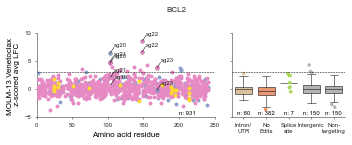

Stem plot: 931
Box plot: 749
Pan lethal: 64
Unaccounted for: 0


In [14]:
col = 'MOLM13_Venetoclax_RepABC;z-score'
fig,ax = stem_box_plot(
    ycol=col,
    df=bcl2,
    xcol='Median Residues',
    ylabel='MOLM-13 Venetoclax \n z-scored avg LFC',
    title='BCL2',
    linepos=[3],
    xlims=[0,250],
    ylims=[-5,10],
    xlabel='Amino acid residue',
    xticks=[0,50,100,150,200,250],
    yticks=[-5,0,5,10],
    n_position = 200,
    d1 = [0,1],
    label_points=validation)

    
fig.savefig('Stem_plot_BCL2_ngABE&CBE.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [15]:
numberOfMutations = {}
stem_plot = ['Silent','Missense','Nonsense']
utr_intron = ['UTR','Intron']
utr_intron_count = 0
stem_plot_count = 0

for mutation in bcl2['Mutation bin'].unique():
    x = len(bcl2[bcl2['Mutation bin'] == mutation])
    numberOfMutations[mutation] = x
    print(mutation + ': ' + str(x))
    if mutation in stem_plot:
        stem_plot_count = stem_plot_count + x
    if mutation in utr_intron:
        utr_intron_count = utr_intron_count + x

print('UTR/Intron: ' + str(utr_intron_count))
print('Stem plot: ' + str(stem_plot_count))

Targeting control: 150
Missense: 720
No edits: 382
Non-targeting control: 150
Silent: 185
Splice site: 7
Intron: 34
Pan-lethal: 64
UTR: 26
Nonsense: 26
UTR/Intron: 60
Stem plot: 931
